In [ ]:
!pip install langchain langchain_core langchain_community langgraph langchain_openai langchain_Groq langchain_experimental duckduckgo-search ddgs

In [ ]:
from typing import Literal , Annotated
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import create_react_agent
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_experimental.utilities import PythonREPL
from langgraph.types import Command
from langchain_core.messages import BaseMessage , HumanMessage

In [ ]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['GROQ_API_KEY'] = userdata.get("GROQ_API_KEY")


In [ ]:
openai_model = ChatOpenAI()
groq_model = ChatGroq(model='deepseek-r1-distill-llama-70b')

In [ ]:
groq_model.invoke("hiii")

AIMessage(content='<think>\n\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 5, 'total_tokens': 21, 'completion_time': 0.063533144, 'prompt_time': 0.017071126, 'queue_time': 0.183625202, 'total_time': 0.08060427}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--3718210e-ff3b-49b9-b406-3291624acbe3-0', usage_metadata={'input_tokens': 5, 'output_tokens': 16, 'total_tokens': 21})

In [ ]:
search_tool =DuckDuckGoSearchResults()
repl = PythonREPL()

In [ ]:
search_tool.invoke('What is the gdp of pakistan?')

'snippet: The economy of Pakistan is categorized as a developing economy. It ranks as the 25th-largest based on GDP using purchasing power parity (PPP) and the 38th largest in terms of nominal GDP ., title: Economy of Pakistan - Wikipedia, link: https://en.wikipedia.org/wiki/Economy_of_Pakistan, snippet: Jun 18, 2025 · The gross domestic product ( GDP ) in current prices in Pakistan was approximately 373.08 billion U.S. dollars in 2024. Between 1980 and 2024, the GDP rose by around 334.46 billion U.S...., title: Gross domestic product (GDP) in current prices Pakistan 2024 ..., link: https://www.statista.com/statistics/383739/gross-domestic-product-gdp-in-pakistan/, snippet: GDP (current US$) - Pakistan Country official statistics, National Statistical Organizations and/or Central Banks; National Accounts data files, Organisation for Economic Co-operation and Development ( OECD ); Staff estimates, World Bank ( WB ), title: GDP (current US$) - Pakistan | Data, link: https://data.worldban

In [ ]:

code = """
x = 5
y = x * 2
print(y)
"""

In [ ]:
repl.run(code)

'10\n'

In [ ]:
@tool
def python_repl_tool(code: Annotated[str, "The python code to execute and generate the Chart"]) :
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""

    try :
      result = repl.run(code)
    except BaseException as e :
      return f"Failed to execute the code. Error :{repr(e)}"

    result_str = f"Successfully executed :\n python \n {code} \n stdout: \n {result}"

    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [ ]:
def make_system_prompt (instruction: str) -> str :
    return  (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

In [ ]:
make_system_prompt(
     "You can only do research. You are working with a chart generator colleague."
    )


"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

In [ ]:
def get_next_node (last_message : BaseMessage, goto:str): # BaseMessage store things luke .content, .name etc
  if "FINAL ANSWER" in last_message.content :
    # Any agent can decide the work is done
    return END

  return goto # name of the next code (agent) in the workflow


In [ ]:

research_agent = create_react_agent(
    openai_model,
    tools=[search_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)

In [ ]:
chart_agent = create_react_agent(
    openai_model,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)

In [ ]:
def research_node(state:MessagesState)->Command[Literal["chart_generator", END]]:

    result = research_agent.invoke(state)

    goto = get_next_node(result["messages"][-1], "chart_generator")

    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")

    return Command(update={"messages": result["messages"]},goto=goto)

In [ ]:

def chart_node(state:MessagesState)-> Command[Literal["researcher", END]]:

    result = chart_agent.invoke(state)

    goto = get_next_node(result["messages"][-1], "researcher")

    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")

    return Command(update={"messages": result["messages"]},goto=goto)

In [ ]:
workflow = StateGraph(MessagesState)

In [ ]:
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
app = workflow.compile()

In [ ]:
app = workflow.compile()

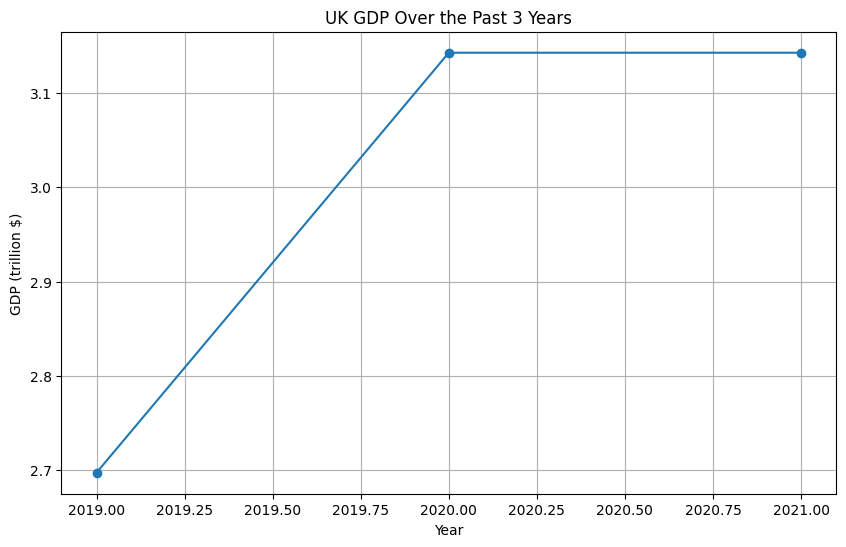

{'messages': [HumanMessage(content="get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='386de7e2-149b-4117-a55c-9f8455c9d322'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Gvc0aWRwPLGvrt1kl9YQiHMN', 'function': {'arguments': '{"query":"UK GDP by year 2019-2021"}', 'name': 'duckduckgo_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 204, 'total_tokens': 231, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CEAJXt8eSy4Cy3187EuTsRjZZXHAS', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2e18147f-0030-4eee-a17f-b

In [ ]:

app.invoke({"messages": [("user","get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.")],})
